<a href="https://colab.research.google.com/github/sayarghoshroy/Optimization_and_Learning/blob/master/Concrete_Compressive_Strength_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Problem 5*

$Regression\ to\ predict\ Concrete\ Compressive\ Strength.$


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from IPython.display import display, HTML

#### $Results:$

In [0]:
# Load 'results.csv' into your working directory
# NOTE: 'results_10k.csv' is an avaiable model trained for 10k epochs
res = pd.read_csv('results.csv')
print("Results after training for 1000 iterations:\n")
HTML(res.to_html(index = False))

Results after training for 1000 iterations:



Index,Size,Active,Method,Train Loss,Test Loss
1,25,relu,simple,98.70,125.43
2,25,relu,rprop,116.68,136.67
3,25,relu,quickprop,281.52,288.60
4,50,relu,simple,84.90,109.44
5,50,relu,rprop,61.32,82.37
6,50,relu,quickprop,154.46,176.80
7,75,relu,simple,73.89,100.18
8,75,relu,rprop,58.10,81.54
9,75,relu,quickprop,144.14,166.13
10,25,tanh,simple,625.63,757.76


In [0]:
# Load 'results_10k.csv' into your working directory
res = pd.read_csv('results_10k.csv')
print("Results after training for 10,000 iterations:\n")
HTML(res.to_html(index = False))

Results after training for 10,000 iterations:



Index,Size,Active,Method,Train Loss,Test Loss
1,25,relu,simple,49.38,82.63
2,25,relu,rprop,51.84,85.81
3,25,relu,quickprop,253.48,257.75
4,50,relu,simple,39.77,65.78
5,50,relu,rprop,27.17,60.49
6,50,relu,quickprop,135.05,157.59
7,75,relu,simple,37.84,62.07
8,75,relu,rprop,26.82,58.47
9,75,relu,quickprop,131.59,153.72
10,25,tanh,simple,147.35,303.64


In [0]:
data_read = pd.read_excel('./Concrete_Data.xls')
data = data_read.values
# the last column of the data is what we are trying to predict
print("Dimensions of the Dataset: " + str(np.shape(data)))

Dimensions of the Dataset: (1030, 9)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data[:, 0:8], data[:, 8], test_size = 0.3, random_state = 42)

In [0]:
train_mean = np.mean(X_train, axis = 0)
train_var = np.mean(X_train, axis = 0)
# Data Normalization
# Note that we are only observing our training set
X_train = (X_train -  train_mean) / np.sqrt(train_var)
X_test = (X_test - train_mean) / np.sqrt(train_var)

#### $ Building\ Neural\ Network\ and\ defining\ Backpropagation\ Equations$

$ y' = W_2.f(W_1^TX)$

$where:$

- $\ W_1\ is\ of\ size\ 8\ \times\ n\_nodes$

- $\ W_2\ is\ of\ size\ 1\ \times\ n\_nodes$

- $\ f\ is\ the\ activation\ for\ the\ hidden\ layer$

- $\ X\ is\ the\ data\ matrix\ of\ size\ 8\times [batch\ size]$

$ Mean\ Squared\ Error = \frac{1}{N}(y - y')^T (y - y') = \frac{1}{N} (y^Ty - y^Ty' - y'^Ty +y'^Ty')$

$ \frac{\partial L}{\partial W_2} = \frac{1}{N}(2y'.\frac{\partial y'}{\partial W_2} - 2y. \frac{\partial y'}{\partial W_2})$
$= \frac{2}{N}(y' - y).f(W_1^TX)$

<b>

$ \frac{\partial L}{\partial W_1} = \frac{2}{N}(y' - y) \frac{\partial y'}{\partial W_1}$
$ = \frac{2}{N}(y' - y).W_2 \odot f'(W_1^T X).X^T$

$ where\ f\ is\ the\ activation\ function$

In [0]:
batch_size = 200

def forward(X, W_1, W_2, f):
    y_prime = np.matmul(W_2, f(np.matmul(W_1.T, X.T)))
    return y_prime

def convergence(losses):
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < 1e-5:
        return True
    return False

def generate_new_eta(old_eta, updater, alpha, beta, eta_min, eta_max):
    eta = np.zeros(old_eta.shape)
    for i in range(eta.shape[0]):
        for j in range(eta.shape[1]):
            if updater[i, j] > 0:
                eta[i, j] = min(old_eta[i, j] * alpha, eta_max)
            elif updater[i, j] < 0:
                eta[i, j] = max(old_eta[i, j] * beta, eta_min)
            else:
                eta[i, j] = old_eta[i, j]
    return eta

def handle_zeros(matrix):
    mat = matrix
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if matrix[i, j] < 1e-20 and matrix[i, j] >= 0:
                mat[i, j] += 1e-20
            if matrix[i, j] > -1e-20 and matrix[i, j] <= 0:
                mat[i, j] -= -1e-20
    return mat

def plot_losses(errors):
    fig = plt.figure(figsize=(7, 7))
    p = fig.add_subplot('111')
    p.set_title('Error v/s Epoch')
    p.set_xlabel('Epoch Number')
    p.set_ylabel('Error')
    losses = [x for x in errors if x < 1500]
    p.plot(list(range(1, len(losses))), losses[1:])
    plt.show()

In [0]:
def batch_backprop_train(nodes, f, f_prime, method = 'simple', random_seed = 2018, max_iter = 1000):
    # method can be 'simple', 'rprop', 'quickprop'
    np.random.seed(seed = random_seed)
    W_1 = np.random.random_sample((8, nodes))
    np.random.seed(seed = random_seed)
    W_2 = np.random.random_sample((1, nodes))

    eta = 1e-4 * 5
    
    iteration = 0

    train_loss = []
    test_loss = []

    if method == 'rprop':
        eta = 1e-3 * 6
        etas_W_1 = [eta * np.ones(W_1.shape)]
        etas_W_2 = [eta * np.ones(W_2.shape)]

        partials_W_1 = [np.zeros(W_1.shape)]
        partials_W_2 = [np.zeros(W_2.shape)]

        alpha = 1.2
        beta = 0.5
        
        eta_min = 1e-8
        eta_max = 1e-1

    if method == 'quickprop':
        eta = 1e-4

        del_W_1 = [np.ones(W_1.shape)]
        del_W_2 = [np.ones(W_2.shape)]
        
        partials_W_1 = [np.zeros(W_1.shape)]
        partials_W_2 = [np.zeros(W_2.shape)]

    while iteration < max_iter:
        # random batch selection
        indices = np.random.randint(0, X_train.shape[0], batch_size)
        sample = X_train[indices]
        y = y_train[indices]

        train_loss.append(np.power(np.linalg.norm(y_train - forward(X_train, W_1, W_2, f)), 2) / np.shape(y_train)[0])
        test_loss.append(np.power(np.linalg.norm(y_test - forward(X_test, W_1, W_2, f)), 2) / np.shape(y_test)[0])
        y_prime = forward(sample, W_1, W_2, f)

        partial_L_W_1 = (2 / batch_size) * (np.multiply( (np.asmatrix(y_prime - y).T @ W_2).T, f_prime(W_1.T @ sample.T)) @ sample).T
        partial_L_W_2 = (2 / batch_size) * np.matmul(np.asmatrix(y_prime - y), f(np.matmul(W_1.T, sample.T).T))

        if method == 'simple':
            W_1 = W_1 - eta * partial_L_W_1
            W_2 = W_2 - eta * partial_L_W_2
        
        elif method == 'rprop':
            updater_W_1 = np.multiply(partial_L_W_1, partials_W_1[-1])
            updater_W_2 = np.multiply(partial_L_W_2, partials_W_2[-1])

            etas_W_1.append(generate_new_eta(etas_W_1[-1], updater_W_1, alpha, beta, eta_min, eta_max))
            etas_W_1.append(generate_new_eta(etas_W_2[-1], updater_W_2, alpha, beta, eta_min, eta_max))

            W_1 = W_1 - np.multiply(etas_W_1[-1], np.sign(partial_L_W_1))
            W_2 = W_2 - np.multiply(etas_W_2[-1], np.sign(partial_L_W_2))

            partials_W_1.append(partial_L_W_1)
            partials_W_2.append(partial_L_W_2)

        elif method == 'quickprop':
            if iteration <= 1:
                W_1 = W_1 - eta * partial_L_W_1
                W_2 = W_2 - eta * partial_L_W_2
                
                del_W_1.append(-1 * eta * partial_L_W_1)
                del_W_2.append(-1 * eta * partial_L_W_2)

                partials_W_1.append(partial_L_W_1)
                partials_W_2.append(partial_L_W_2)

                iteration += 1
                continue

            del_W_1.append(-1 * np.multiply(partial_L_W_1, del_W_1[-1]) / handle_zeros(partial_L_W_1 - partials_W_1[-1]))
            del_W_2.append(-1 * np.multiply(partial_L_W_2, del_W_2[-1]) / handle_zeros(partial_L_W_2 - partials_W_2[-1]))
            
            partials_W_1.append(partial_L_W_1)
            partials_W_2.append(partial_L_W_2)

            W_1 = W_1 - del_W_1[-1]
            W_2 = W_2 - del_W_2[-1]
        
        iteration += 1

    return train_loss, test_loss, W_1, W_2

### $Computing\ Results\ for\ all\ possible\ cases:$

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = relu
Method Used = simple
MSE on Train Set: 102.06013818075195
MSE on Test Set: 127.49706039869169


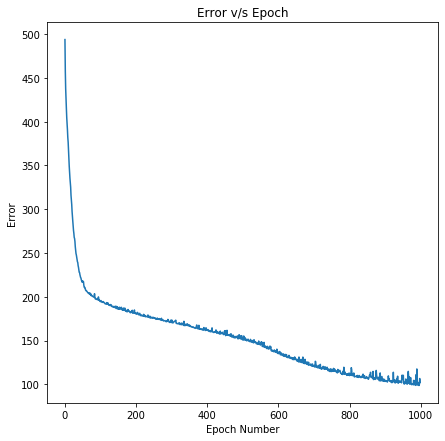

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = relu
Method Used = rprop
MSE on Train Set: 118.82493552012568
MSE on Test Set: 138.3335959687999


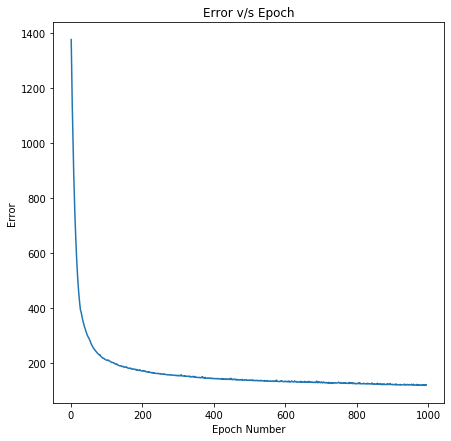

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = relu
Method Used = quickprop
MSE on Train Set: 341.87786025208993
MSE on Test Set: 353.972480446597


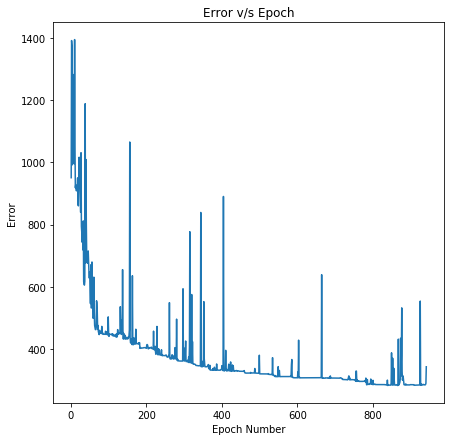

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = relu
Method Used = simple
MSE on Train Set: 89.36395779784647
MSE on Test Set: 109.77253600449453


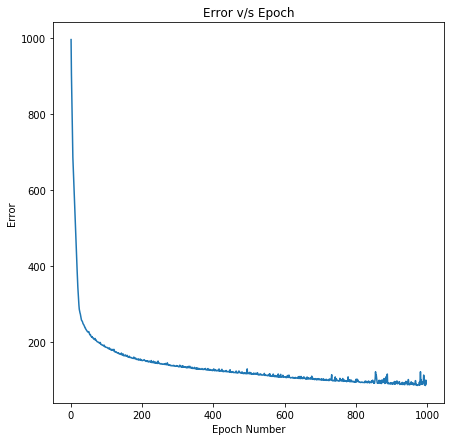

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = relu
Method Used = rprop
MSE on Train Set: 62.45629895140599
MSE on Test Set: 83.83102683271595


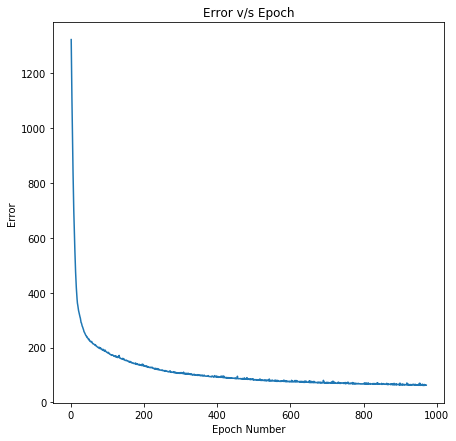

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = relu
Method Used = quickprop
MSE on Train Set: 154.6158426696359
MSE on Test Set: 177.62371895225846


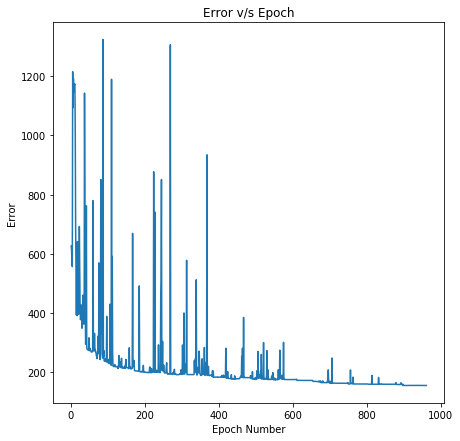

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = relu
Method Used = simple
MSE on Train Set: 81.11032194323786
MSE on Test Set: 107.6016340734491


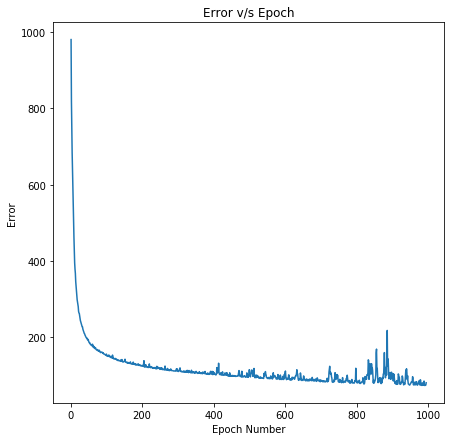

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = relu
Method Used = rprop
MSE on Train Set: 59.476054597193254
MSE on Test Set: 84.16703633855312


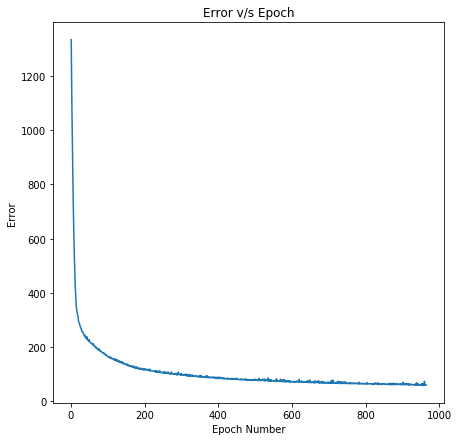

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = relu
Method Used = quickprop
MSE on Train Set: 144.32375430477643
MSE on Test Set: 166.48735829475143


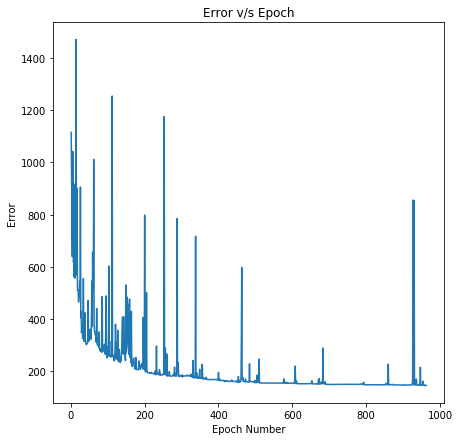

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = tanh
Method Used = simple
MSE on Train Set: 625.695429645406
MSE on Test Set: 759.9937721856434


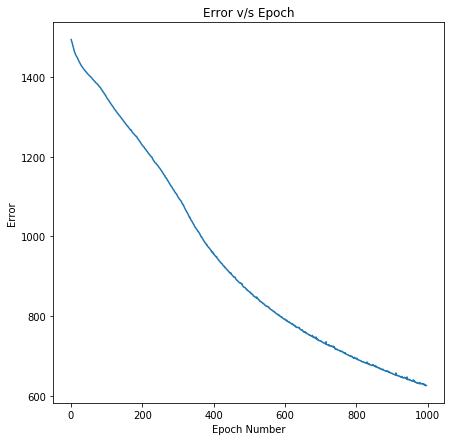

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = tanh
Method Used = rprop
MSE on Train Set: 632.1386128553562
MSE on Test Set: 780.696872281395


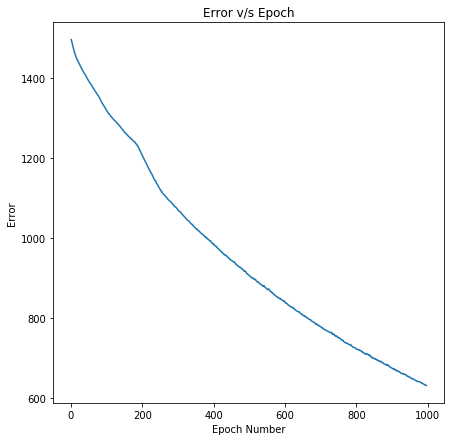

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = tanh
Method Used = quickprop
MSE on Train Set: 939.1137382298568
MSE on Test Set: 1195.9876715075006


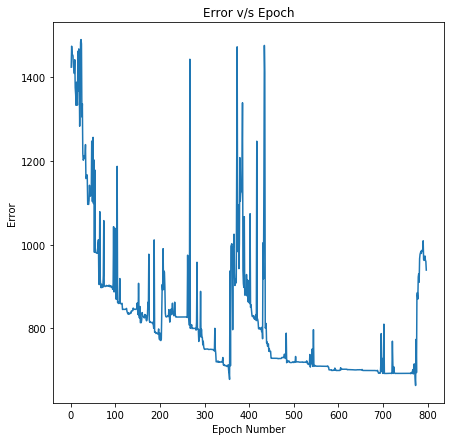

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = tanh
Method Used = simple
MSE on Train Set: 380.53085267160606
MSE on Test Set: 487.0707962118987


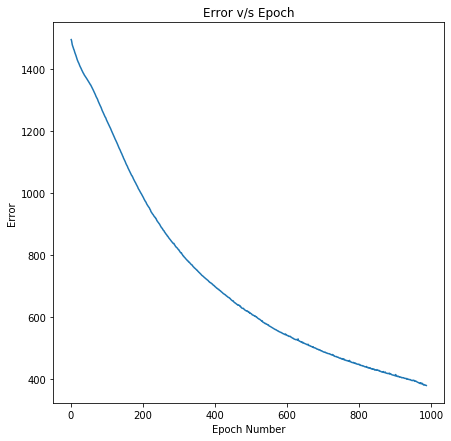

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = tanh
Method Used = rprop
MSE on Train Set: 286.12607915207786
MSE on Test Set: 441.8832483089208


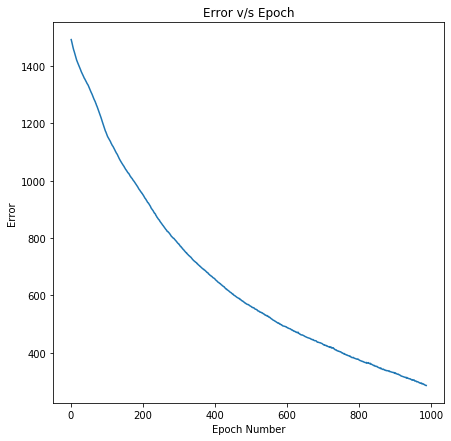

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = tanh
Method Used = quickprop
MSE on Train Set: 945.3733863195627
MSE on Test Set: 1081.1038573693206


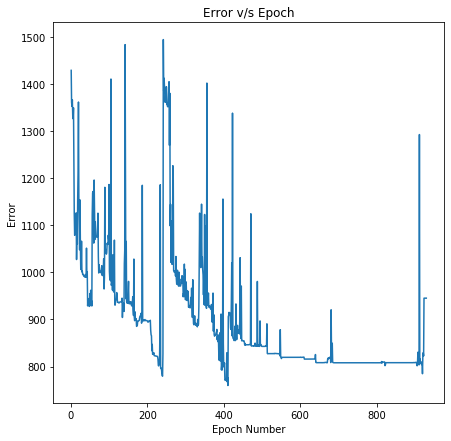

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = tanh
Method Used = simple
MSE on Train Set: 285.3275524667191
MSE on Test Set: 416.01560388607373


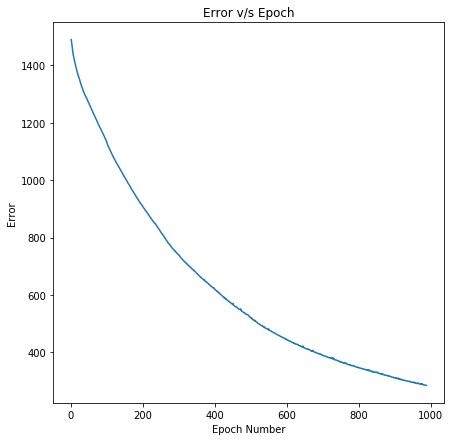

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = tanh
Method Used = rprop
MSE on Train Set: 194.42944675315846
MSE on Test Set: 342.2491322251726


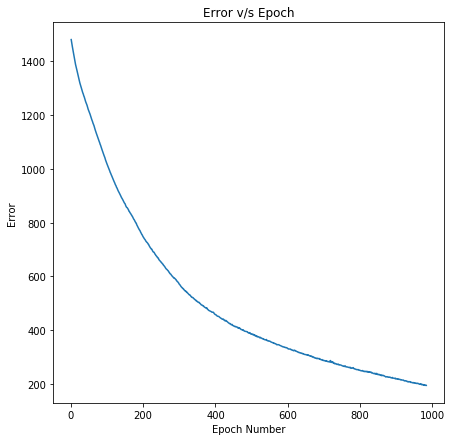

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = tanh
Method Used = quickprop
MSE on Train Set: 690.0615203227475
MSE on Test Set: 757.8576033661416


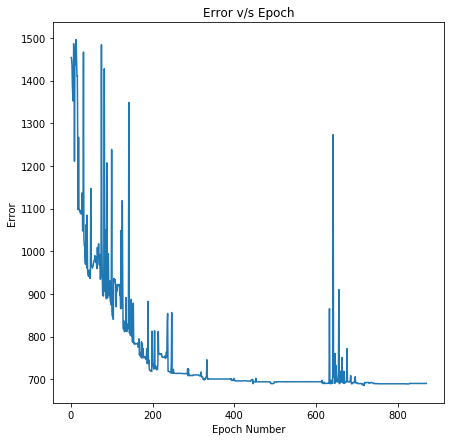

In [0]:
activations = ['relu', 'tanh']
n_nodes = [25, 50, 75]
methods = ['simple', 'rprop', 'quickprop']

report = []

get_f = {'tanh' : (lambda x: np.tanh(x)), 'relu': (lambda x: np.maximum(0, x))}
get_f_prime = {'tanh': (lambda x: 1 - np.power(np.tanh(x), 2)), 'relu': (lambda x: np.greater(x, 0))}

for active in activations:
    for n_node in n_nodes:
        for method in methods:
            train_loss, test_loss, _, _ = batch_backprop_train(n_node, get_f[active], get_f_prime[active], method = method)
            print("Number of Nodes in Hidden Layer = " + str(n_node))
            print("Hidden Layer Activation = " + str(active))
            print("Method Used = " + str(method))
            print("MSE on Train Set: " + str(train_loss[-1]))
            print("MSE on Test Set: " + str(test_loss[-1]))
            report.append([n_node, active, method, min(train_loss), test_loss[np.argmin(train_loss)]])
            plot_losses(train_loss)

---

#### $Comments\ on\ Results:$
 - $ReLU\ gives\ better\ results\ than\ tanh$
 - $simple\ backprop\ and\ rprop\ give\ approximately\ convex\ graphs\ with\ some\ fluctuations$
 - $quickprop\ shows\ a\ lot\ oscillations\ and\ upscaling\ but\ the\ trend\ is\ downwards\ in\ general$
 - $ note\ that\ the\ number\ of\ epochs\ was\ capped\ at\ 1000 $
 - $ further\ finetuning\ of\ hyperparameters\ can\ lead\ to\ better\ results $
 - $ weights\ were\ initialized\ randomly $
 - $ initialization\ greatly\ affects\ the\ results $

$Clearly,\ ReLU\ activation\ with\ 75\ hidden\ units\ optimized\ using\ rprop\ was\ the\ best\ model$

$ Trying\ models\ trained\ for\ higher\ number\ of\ epochs:$

- $ReLU\ activation\ with\ 75\ hidden\ cells\ trained\ with\ rprop\ consistently\ stayed\ the\ best\ model$

- $Results\ for\ models\ trained\ for\ greater\ number\ of\ epochs\ have\ been\ provided\ -\ refer\ to\ $ **results\_10k.csv**

---

In [0]:
# Rounding Losses
for i in range(len(report)):
    for j in range(3, 5):
        report[i][j] = (round(report[i][j], 2))

In [0]:
# Creating and Saving the Table
values = np.asmatrix(report)
heads = ['Size', 'Active', 'Method', 'Train Loss', 'Test Loss']
df = pd.DataFrame(data = values[:, :], index=[(i + 1) for i in range(values.shape[0])], columns = heads)
df.index.name = 'Index'
# Uncomment the following line to view the table
# display(df)

# Uncomment the following line to save the table
# df.to_csv('results.csv')

---
$ Using\ scikit-learn's\ inbuilt\ functionality $

$> with\ 10^4\ iterations $

---

In [0]:
# Sklearn Implementation of SGD with 10000 iterations
def train(X, y, n_nodes = 25, active = 'relu'):
    reg = MLPRegressor(alpha = 0,
                       learning_rate_init = 1e-4 * 5,
                       hidden_layer_sizes = (n_nodes),
                       random_state = 2018,
                       activation = active,
                       max_iter = 1000,
                       solver = 'sgd',
                       momentum = 0)
    reg.fit(X, y)
    return reg
    # reg is our trained model
    
def plot_loss_curve(reg):
    fig = plt.figure(figsize=(7, 7))
    p = fig.add_subplot('111')
    p.set_title('Error v/s Epoch')
    p.set_xlabel('Epoch Number')
    p.set_ylabel('Error')
    errors = reg.loss_curve_
    p.plot(list(range(1, len(errors))), errors[1:])
    plt.show()

def get_train_test_loss(reg):
    pred_y_train = reg.predict(X_train)
    pred_y_test = reg.predict(X_test)
    
    train_Loss = np.power(np.linalg.norm(y_train - pred_y_train), 2) / np.shape(y_train)[0]
    test_Loss = np.power(np.linalg.norm(y_test - pred_y_test), 2) / np.shape(y_test)[0]

    return (train_Loss, test_Loss)

---

$ Results\ using\ sklearn\ SGD\ for\ 10000\ iterations $ 

---

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = tanh
Error on Train Set: 28.968079732872635
Error on Test Set: 37.4246617267181


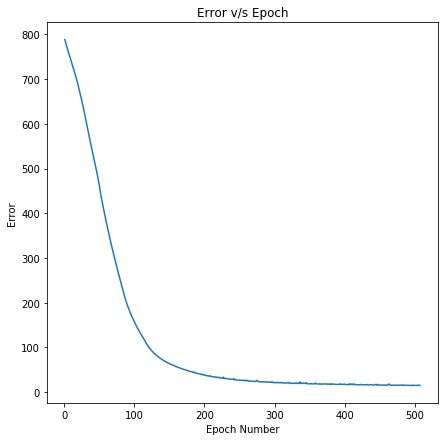

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = tanh
Error on Train Set: 26.554831704289565
Error on Test Set: 35.161105632328436


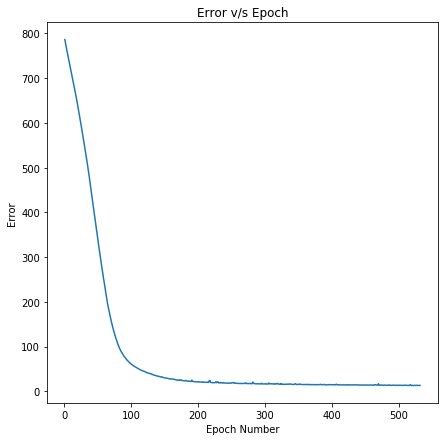

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = tanh
Error on Train Set: 28.522454622306256
Error on Test Set: 38.06264716362339


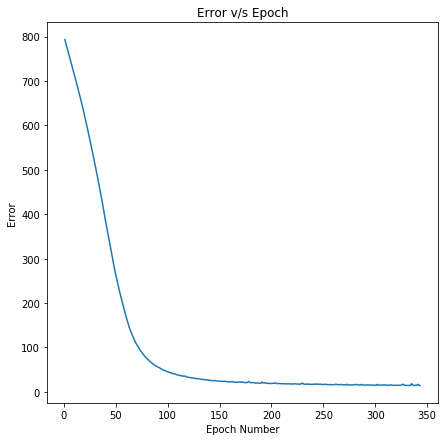

Number of Nodes in Hidden Layer = 25
Hidden Layer Activation = relu
Error on Train Set: 57.5312824677546
Error on Test Set: 68.88434517127527


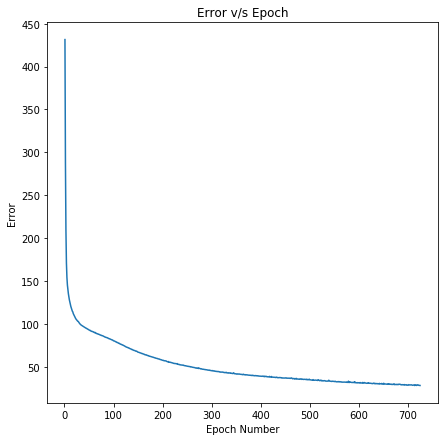

Number of Nodes in Hidden Layer = 50
Hidden Layer Activation = relu
Error on Train Set: 48.40846035983305
Error on Test Set: 59.54763447465806


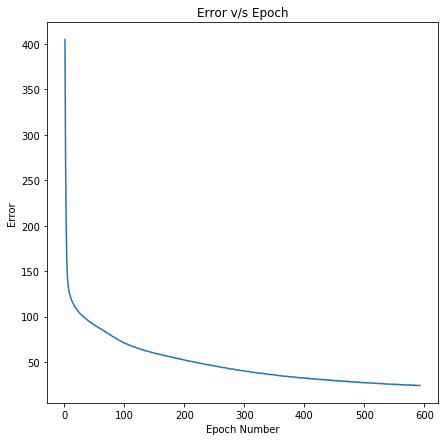

Number of Nodes in Hidden Layer = 75
Hidden Layer Activation = relu
Error on Train Set: 37.277459879347305
Error on Test Set: 49.19992660535597


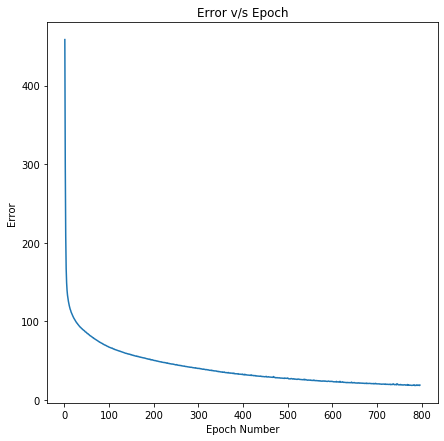

In [0]:
activations = ['tanh', 'relu']
n_nodes = [25, 50, 75]

for active in activations:
    for n_node in n_nodes:
        model = train(X_train, y_train, n_node, active)
        print("Number of Nodes in Hidden Layer = " + str(n_node))
        print("Hidden Layer Activation = " + str(active))
        loss_train, loss_test = get_train_test_loss(model)
        print("Error on Train Set: " + str(loss_train))
        print("Error on Test Set: " + str(loss_test))
        plot_loss_curve(model)

---

$Thank\ You$

---